In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import colorsys
import warnings
from datetime import timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=UserWarning)

#### Import machine and ruby data

In [2]:
# import all data
removable_features= ['Produkt [None]', 'Auftragsnummer [None]', 'utc_time', 'Blasentemperatur [°C]', 'Wickler A Steigung (Soll) [%]', 'Wickler A Steigung [%]', 'Wickler B Steigung (Soll) [%]', 'Wickler B Steigung [%]']
first_dataset = pd.read_csv("../data/merged_week_21_50-22_15.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns') 
second_dataset = pd.read_csv("../data/merged_week_22_17-22_28.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns') 
data = pd.concat([first_dataset, second_dataset], ignore_index=True)
data['local_time'] = pd.to_datetime(data['local_time'], format="%d.%m.%Y %H:%M")

# define numeric data
numeric_columns = data.select_dtypes(include='number').drop(['product_code [None]', 'production_order_code [None]'], axis=1).loc[:, data.nunique() > 150].columns.tolist()
numeric_data_aggregated = data[['local_time'] + numeric_columns].groupby(pd.Grouper(key="local_time", freq="1min")).mean().reset_index(level=['local_time'])
int_columns = data[numeric_data_aggregated.columns.to_list()].select_dtypes(include='int').columns.tolist()
numeric_data_aggregated[int_columns] = numeric_data_aggregated[int_columns].round().astype(pd.Int64Dtype())

# import ruby data
first_warnings = pd.read_excel('../data/old_Warnings.xlsx')
second_warnings = pd.read_excel('../data/new_warnings.xlsx')#.drop(['Component', 'Summarized Warnings', 'Possible Failure', 'Mark here if relevant for Maintenance'], axis=1)
warnings_imp = pd.concat([first_warnings, second_warnings], ignore_index=True)
warnings_imp["Start"] = pd.to_datetime(warnings_imp["Start"].dt.strftime('%Y-%m-%d %H:%M:00'), format="%Y.%m.%d %H:%M:%S")
warnings_imp["End"] = pd.to_datetime(warnings_imp["Start"].dt.strftime('%Y-%m-%d %H:%M:00'), format="%Y.%m.%d %H:%M:%S")
warnings_imp = warnings_imp.sort_values(by="Start", ascending=True)
#warnings = warnings_imp.drop_duplicates(subset=['Start']) # remove total duplicates

/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_13142/1296706149.py:3: DtypeWarning: Columns (4,15,32,44,51,72,75,81,99,125,150,164,167,248,261) have mixed types. Specify dtype option on import or set low_memory=False.
  first_dataset = pd.read_csv("../data/merged_week_21_50-22_15.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns')
/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_13142/1296706149.py:4: DtypeWarning: Columns (4,15,32,44,51,72,75,81,99,125,150,164,167,218,248,261,267,281) have mixed types. Specify dtype option on import or set low_memory=False.
  second_dataset = pd.read_csv("../data/merged_week_22_17-22_28.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns')


#### Filter warnings

In [3]:
def filter_warnings(warnings, filter_list): 
    mask = pd.Series(False, index=warnings.index)
    for substring in filter_list:
        mask |= warnings['Warning Text'].str.contains(substring)
    
    return warnings.loc[mask]

def remove_duplicates(warnings, time_diff):
    diff = warnings['Start'].diff() # Calculate the time difference between consecutive rows
    duplicate_rows = diff < timedelta(minutes=time_diff) # Find rows where the time difference is less than 5 minutes

    return warnings[~duplicate_rows] # Remove the duplicate rows within the same <time_diff> minutes

filter = ["Excess temperature", "heating"]
warnings = filter_warnings(warnings_imp, filter) # filters warnings by Warning text with OR operator
warnings = remove_duplicates(warnings, 5) # removes entries which are closer than 5 minutes

print(len(warnings))
warnings.head(25)

50


,Start,End,Type,Code,Comp,Warning Text
133,2021-12-19 23:13:00,2021-12-19 23:13:00,Warning,1-869,Extruder 1,Extruder A heating
79,2021-12-21 17:47:00,2021-12-21 17:47:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
78,2021-12-21 18:33:00,2021-12-21 18:33:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
64,2021-12-23 11:36:00,2021-12-23 11:36:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
60,2021-12-23 17:25:00,2021-12-23 17:25:00,Warning,61-1421,Plc IPC,Excess temperature heater Film cooling
153,2022-01-02 03:51:00,2022-01-02 03:51:00,Warning,10-878,Die head,Die head heating
233,2022-01-02 14:21:00,2022-01-02 14:21:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
450,2022-01-02 20:30:00,2022-01-02 20:30:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
265,2022-01-12 22:20:00,2022-01-12 22:20:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
262,2022-01-12 22:29:00,2022-01-12 22:29:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B


#### Create Labels couting down the time until next alarm 

In [4]:
numeric_data_aggregated['Label'] = numeric_data_aggregated['local_time'].apply(lambda x: 1 if x in warnings['Start'].to_list() else 0) # markt overheating timestamps with 1 else 0
last_failure_index = numeric_data_aggregated.loc[numeric_data_aggregated['local_time'] == warnings['Start'].to_list()[len(warnings['Start'].to_list()) -1]].index[0] # list of failure indices
data_until_last_failure = numeric_data_aggregated[:last_failure_index +1] # cuts data after last failure

data_until_last_failure

,local_time,Reversierung Luftwendestange unten [%],Extruder B NK3 Förderrate [kg/U/min],Extruder B Drehzahl [1/min],Extruder A HK Durchsatz [kg/h],Extruder B NK 1 Durchsatz [kg/h],Extruder B NK 4 Durchsatz [kg/h],Wickler B Anpresskraft [N],Extruder B NK2 Förderrate [kg/U/min],Extruder C NK 3 Durchsatz [kg/h],Extruder A AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder A NK 3 Anteil [%],Extruder A NK 4 Durchsatz [kg/h],Extruder A NK3 Förderrate [kg/U/min],Blaskopf Zone 4 Temperatur [°C],Extruder B Schichtdicke [µm],Extruder B HK Durchsatz [kg/h],Wobble Median [mm],Gleitende Profiltoleranz [%],Extruder B NK 2 Ausstoß maximal (Soll) [kg/h],Extruder C HK Anteil [%],Blaskopf Zone 2 Temperatur [°C],Extruder A Massetemperatur [°C],Extruder B NK 4 Ausstoß maximal (Soll) [kg/h],Extruder C Zone 3 Temperatur [°C],Wärmetauscher Kühlleistung [kW],Extruder A Schichtdicke [µm],Blaskopf Zone 5 Temperatur [°C],Korbbreite [mm],Extruder C NK 4 Drehzahl [1/min],Blaskopf Zone 6 Temperatur [°C],Extruder B NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B Durchsatz [kg/h],Flachlegewinkel [°],Extruder B NK1 Förderrate [kg/U/min],Blaskopf Zone 7 Temperatur [°C],Extruder A NK1 Förderrate [kg/U/min],Ultraschall Breite Regelabweichung [mm],Extruder B NK 3 Anteil [%],Extruder B NK 5 Ausstoß maximal (Soll) [kg/h],Reversierung Luftwendestange oben [%],Spezifische Energie gesamt [kWh/kg],Frostlinie Durchmesser [mm],Extruder C NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B NK5 Förderrate [kg/U/min],Kühlring Stabilisator Ebene 1 Höhe [%],Extruder C Massedruck [bar],Mittelwert Foliendicke [µm],Wickler A Anpresskraft [N],Abzug Zentralführung [mm],Extruder C NK 3 Drehzahl [1/min],Extruder C Drehzahl [1/min],Extruder B Massetemperatur [°C],Druckluftverbrauch [Nm3/h],Extruder C Förderrate [kg/U/min],Extruder B Zone 3 Temperatur [°C],Folienprofil 3-Sigma [%],Extruder A NK 4 Ausstoß maximal (Soll) [kg/h],Blaskopf Zone 1 Temperatur [°C],Breite (Soll) [mm],Extruder A NK5 Förderrate [kg/U/min],Extruder C Durchsatz [kg/h],Extruder B NK 5 Anteil [%],Extruder C NK5 Förderrate [kg/U/min],Ist-Breite dfl [mm],Extruder B NK 5 Durchsatz [kg/h],Maschinenkühlung Kühlleistung [kW],Extruder A Massedruck [bar],Reversierwinkel [°],Extruder B NK 4 Anteil [%],Vorbehandlung Spezifische Energie Ist [Wmin/m2],Extruder A NK 4 Drehzahl [1/min],Extruder A Zone 2 Temperatur [°C],Extruder B NK4 Förderrate [kg/U/min],Extruder B Zone 4 Temperatur [°C],Wickler B Zentralantrieb Kraft [N],Extruder B NK 5 Drehzahl [1/min],Extruder C Siebwechsler Temperatur [°C],Blaskopf Zone 9 Temperatur [°C],Extruder C NK 4 Durchsatz [kg/h],Extruder B Zone 1 Temperatur [°C],Extruder A NK 3 Durchsatz [kg/h],Extruder A Drehzahl [1/min],Extruder A NK 5 Ausstoß maximal (Soll) [kg/h],Extruder B Laufmetergewicht [g/m],Elektrische Leistung Gesamt [kW],Extruder A Zone 3 Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Leistung [kW],Extruder B HK Anteil [%],Extruder B Förderrate [kg/U/min],Korbhöhe [mm],Innen Abluft [%],Breite [mm],Blaskopf Zone 3 Temperatur [°C],Extruder B NK 3 Durchsatz [kg/h],Extruder C NK 5 Ausstoß maximal (Soll) [kg/h],Extruder B Massedruck [bar],Extruder B NK 3 Drehzahl [1/min],Kühlring Stabilisator Ebene 3 Höhe [%],Wickler A Zentralantrieb Kraft [N],Extruder A NK4 Förderrate [kg/U/min],Kühlring Stabilisator Ebene 2 Höhe [%],Extruder A NK 3 Drehzahl [1/min],Extruder A NK 1 Anteil [%],Extruder C NK3 Förderrate [kg/U/min],Blaskopf Zone 10 Temperatur [°C],Dickenmessung Zentrierrichtung (diagonal) [°],Extruder B AF1 Temperatur [°C],Extruder C NK1 Förderrate [kg/U/min],Foliendicke Mittelwert [μm],Extruder A NK 3 Ausstoß maximal (Soll) [kg/h],Extruder B NK 1 Drehzahl [1/min],Dickenmessung Zentrierbetrag (diagonal) [%],Kennwert Profilverteilung [-],Extruder C NK4 Förderrate [kg/U/min],Blaskopf Zone 8 Temperatur [°C],Extruder A NK2 Förderrate [kg/U/min],Extruder C Zone 4 Temperatur [°C],Extruder A NK 4 Anteil [%],Abzug Flachlegung [mm],Extruder A Zone 4 Temperatur [°C],Extruder B Zone 2 Tempera

#### Only consider specific features and remove NaN values

In [5]:
col_search_words = ['Temperatur', 'Extruder'] # Only consider columns with these words in name
standard_columns = ['local_time', 'Label']

# Select columns containing any word from the list
searched_columns = [col for col in data_until_last_failure.columns if all(word in col for word in col_search_words)]
selected_columns = standard_columns + np.sort(np.array(searched_columns)).tolist()

data_without_nan = data_until_last_failure[selected_columns].dropna(subset=searched_columns, how='all').reset_index().drop(['index'], axis=1)
#data_without_nan.to_csv('data/data_with_overheating_label.csv', index=False, sep=';', decimal = ".")

In [13]:
# Find rows with Label == 1
label_rows = data_without_nan[data_without_nan['Label'] == 1].index

for index, label_row in enumerate(label_rows):
    if label_row > 20:
        x_minutes_before_index = label_row - 20
        data_without_nan.loc[x_minutes_before_index:label_row, 'Label'] = 1

data_without_nan

,local_time,Label,Extruder A AF1 Temperatur [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder B Zone 1 Temperatur [°C],Extruder B Zone 2 Temperatur [°C],Extruder B Zone 3 Temperatur [°C],Extruder B Zone 4 Temperatur [°C],Extruder C AF1 Temperatur [°C],Extruder C Siebwechsler Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Extruder C Zone 2 Temperatur [°C],Extruder C Zone 3 Temperatur [°C],Extruder C Zone 4 Temperatur [°C]
0,2021-12-13 00:00:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
1,2021-12-13 00:01:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
2,2021-12-13 00:02:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
3,2021-12-13 00:03:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
4,2021-12-13 00:04:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281874,2022-07-08 23:53:00,1,201,200,198,190,190,195,199,180,201,179,180,180,194,180,180,180,180,180
281875,2022-07-08 23:54:00,1,201,200,198,190,190,195,199,180,201,180,179,180,194,180,180,180,180,180
281876,2022-07-08 23:55:00,1,201,200,198,190,190,195,200,180,201,180,179,180,194,180,180,180,180,180
281877,2022-07-08 23:56:00,1,201,200,198,190,190,194,200,180,201,180,179,180,195,180,179,180,180,180


In [14]:
def remove_sample_of_normal_data(dataset, percentage):
    count_10000 = dataset[dataset['Label'] == 0].shape[0]  # Count the number of rows with value 10000
    rows_to_keep = dataset[dataset['Label'] == 0].sample(n=int((1- percentage / 100) * count_10000), random_state=42) # Randomly select rows to remove
    dataset = pd.concat([dataset[dataset['Label'] != 0], rows_to_keep]) # Concatenate the rows to keep with the remaining rows
    dataset = dataset.sort_values(by="local_time", ascending=True)

    return dataset

data_without_nan = remove_sample_of_normal_data(data_without_nan, 95)    
data_without_nan

,local_time,Label,Extruder A AF1 Temperatur [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder B Zone 1 Temperatur [°C],Extruder B Zone 2 Temperatur [°C],Extruder B Zone 3 Temperatur [°C],Extruder B Zone 4 Temperatur [°C],Extruder C AF1 Temperatur [°C],Extruder C Siebwechsler Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Extruder C Zone 2 Temperatur [°C],Extruder C Zone 3 Temperatur [°C],Extruder C Zone 4 Temperatur [°C]
24,2021-12-13 00:24:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
26,2021-12-13 00:26:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
41,2021-12-13 00:41:00,0,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
87,2021-12-13 01:27:00,0,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
88,2021-12-13 01:28:00,0,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281874,2022-07-08 23:53:00,1,201,200,198,190,190,195,199,180,201,179,180,180,194,180,180,180,180,180
281875,2022-07-08 23:54:00,1,201,200,198,190,190,195,199,180,201,180,179,180,194,180,180,180,180,180
281876,2022-07-08 23:55:00,1,201,200,198,190,190,195,200,180,201,180,179,180,194,180,180,180,180,180
281877,2022-07-08 23:56:00,1,201,200,198,190,190,194,200,180,201,180,179,180,195,180,179,180,180,180


In [15]:
second_last_warning_entry = data_without_nan.loc[data_without_nan['Label'] == 1].index.to_list()[-4] # index of second last overheating entry
last_cycle = data_without_nan.loc[data_without_nan.index > second_last_warning_entry]
all_other_cycles= data_without_nan.loc[data_without_nan.index <= second_last_warning_entry]
print(second_last_warning_entry)
data_without_nan.loc[second_last_warning_entry:]

281875


,local_time,Label,Extruder A AF1 Temperatur [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder B Zone 1 Temperatur [°C],Extruder B Zone 2 Temperatur [°C],Extruder B Zone 3 Temperatur [°C],Extruder B Zone 4 Temperatur [°C],Extruder C AF1 Temperatur [°C],Extruder C Siebwechsler Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Extruder C Zone 2 Temperatur [°C],Extruder C Zone 3 Temperatur [°C],Extruder C Zone 4 Temperatur [°C]
281875,2022-07-08 23:54:00,1,201,200,198,190,190,195,199,180,201,180,179,180,194,180,180,180,180,180
281876,2022-07-08 23:55:00,1,201,200,198,190,190,195,200,180,201,180,179,180,194,180,180,180,180,180
281877,2022-07-08 23:56:00,1,201,200,198,190,190,194,200,180,201,180,179,180,195,180,179,180,180,180
281878,2022-07-08 23:57:00,1,201,200,198,189,190,195,200,180,201,180,180,180,195,180,179,180,180,180


#### Prediction

Define training, validation and test dataset

In [16]:
#training, validation & test data
train_data, val_data = train_test_split(all_other_cycles, test_size=0.2, random_state=42)
test_data = last_cycle

y_train, X_train = train_data.to_numpy()[:,1:2], train_data.to_numpy()[:,2:]
y_val, X_val = val_data.to_numpy()[:,1:2], val_data.to_numpy()[:,2:]
y_test, X_test = test_data.to_numpy()[:,1:2], test_data.to_numpy()[:,2:]

In [17]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=600,
    objective='binary:logistic',
    random_state=42
)

#%time grid_search.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train),(X_val, y_val)])
%time model.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train),(X_val, y_val)])

[0]	validation_0-logloss:0.62225	validation_1-logloss:0.62321
[1]	validation_0-logloss:0.56426	validation_1-logloss:0.56553
[2]	validation_0-logloss:0.51596	validation_1-logloss:0.51814
[3]	validation_0-logloss:0.47454	validation_1-logloss:0.47770
[4]	validation_0-logloss:0.43918	validation_1-logloss:0.44283
[5]	validation_0-logloss:0.40733	validation_1-logloss:0.41198
[6]	validation_0-logloss:0.38075	validation_1-logloss:0.38616
[7]	validation_0-logloss:0.35560	validation_1-logloss:0.36132
[8]	validation_0-logloss:0.33398	validation_1-logloss:0.33986
[9]	validation_0-logloss:0.31499	validation_1-logloss:0.32160
[10]	validation_0-logloss:0.29858	validation_1-logloss:0.30586
[11]	validation_0-logloss:0.28401	validation_1-logloss:0.29199
[12]	validation_0-logloss:0.27143	validation_1-logloss:0.27977
[13]	validation_0-logloss:0.26010	validation_1-logloss:0.26942
[14]	validation_0-logloss:0.24868	validation_1-logloss:0.25822
[15]	validation_0-logloss:0.24065	validation_1-logloss:0.25047
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

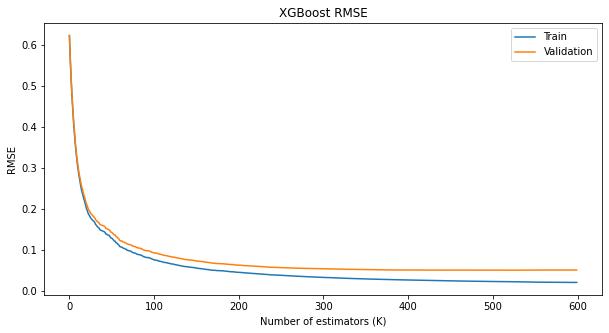

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
ax.set_title('XGBoost RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('Number of estimators (K)')
plt.show()
plt.tight_layout()

In [25]:
prediction = model.predict(X_test)

RMSE: 0.0


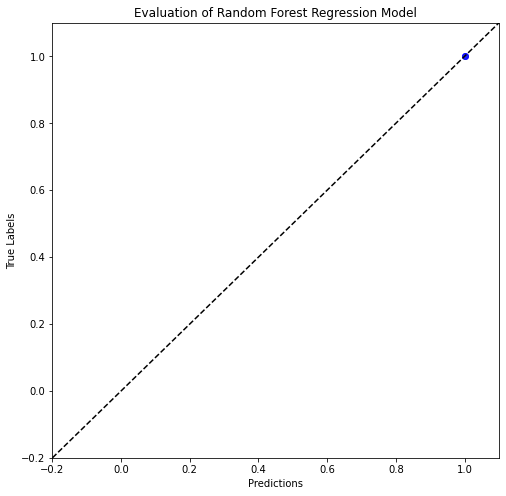

In [21]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, prediction))))

max_value = 1.1
min_value = -0.2

# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(prediction, y_test, color="blue", alpha=0.5)
plt.xticks(rotation=0)

# Define a custom formatter to display decimal values
#formatter = mticker.StrMethodFormatter('{x:.2f}')
#plt.gca().xaxis.set_major_formatter(formatter)

plt.plot([min_value, max_value], [min_value, max_value], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([min_value, max_value])
plt.ylim([min_value, max_value])
plt.title("Evaluation of Random Forest Regression Model")
plt.show()